In [2]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
SAVE_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase/results'
import pandas as pd
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

In [3]:
def load_results(DATASET):
    with open(f'{ROOT_DIR}/results/{DATASET}/{DATASET}_scores_full.pkl', 'rb') as f :
        results_full = pickle.load(f)
    with open(f'{ROOT_DIR}/results/{DATASET}/{DATASET}_scores_personal.pkl', 'rb') as f :
        results_new_personal = pickle.load(f)
    #Replace the personalised algos with newly optimized results
    for cost_key in results_full:
        if 'pfedme' in results_full[cost_key]:
            results_full[cost_key]['pfedme'] = results_new_personal[cost_key]['pfedme']
        if 'ditto' in results_full[cost_key]:
            results_full[cost_key]['ditto'] = results_new_personal[cost_key]['ditto']

    return results_full
    
def bootstrap_ci(data, alpha=0.95):
    estimates = {}
    for c in data:
        estimates[c]={}
        for arch in data[c]:
            res = data[c][arch]
            median = np.mean(res)
            bs_reps = bootstrap(np.array(res).reshape(1,-1), statistic=np.mean, n_resamples=1000)
            ci = bs_reps.confidence_interval[0:2]
            estimates[c][arch] = (median, ci[0], ci[1])
    return estimates

def bootstrap_samples(data, n_iterations):
    n = len(data)
    indices = np.random.randint(0, n, (n_iterations, n))
    return data[indices]

def get_difference_estimates(results):
    results_diff = {}
    n_iterations = 1000
    for cost in results:
        results_diff[cost] = {}
        for architecture in list(results[cost].keys())[1:]:
            single = np.array(results[cost]['single'])
            other = np.array(results[cost][architecture])
            bs_single_samples = bootstrap_samples(single, n_iterations)
            bs_other_samples = bootstrap_samples(other, n_iterations)
            bs_single_means = np.median(bs_single_samples, axis=1)
            bs_other_means = np.median(bs_other_samples, axis=1)
            bs_diff = bs_other_means - bs_single_means 
            mean_single = np.median(single)
            median_diff = 100 * np.percentile(bs_diff, 50) / mean_single
            lower_ci_diff = 100 * np.percentile(bs_diff, 5) / mean_single
            upper_ci_diff = 100 * np.percentile(bs_diff, 95) / mean_single
            results_diff[cost][architecture] = (np.round(median_diff, 3), np.round(lower_ci_diff, 3), np.round(upper_ci_diff, 3))
    return pd.DataFrame.from_dict(results_diff, orient='index')

def print_med_results(DATASET):
    results = load_results(DATASET)
    for arch in ['single', 'joint', 'federated', 'pfedme', 'ditto']:
        print(arch)
        for c in results:
            print(np.median(results[c][arch]))
        print('----')

def grapher(results, DATASET, metric, costs, save):
    results_long = results.reset_index().rename(columns={'index': 'cost'}).melt(id_vars=['cost'], var_name='architecture')
    results_long[['median_diff', 'lower_ci_diff', 'upper_ci_diff']] = pd.DataFrame(results_long['value'].tolist(), index=results_long.index)
    results_long.drop(columns=['value'], inplace=True)
    results_long
    plt.figure()
    for architecture in results_long['architecture'].unique():
        subset = results_long[results_long['architecture'] == architecture]
        sns.lineplot(x='cost', y='median_diff', marker = 'o', data=subset, label=architecture.capitalize())
        if DATASET not in ['IXITiny', 'ISIC']:
            plt.fill_between(x=subset['cost'], y1=subset['lower_ci_diff'], y2=subset['upper_ci_diff'], alpha=0.2)
    plt.axhline(y=0, color='black', linestyle = '--', alpha = 0.5, label = 'Baseline')
    plt.xlabel('Dataset dissimilarity score', fontsize = 14)
    plt.ylabel(f'% Change in {metric}', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    if save == True:
        plt.savefig(f'{SAVE_DIR}/{DATASET}/{DATASET}_scores_change.pdf', bbox_inches='tight')
    plt.show()

def process_results(DATASET):
    dataset_dict = {'Synthetic':['F1', '0.03-0.6'],
                'Credit': ['F1', '0.12-0.40'],
                'Weather': ['R2', '0.11-0.48'],
                'EMNIST': ['Accuracy', '0.11-0.39'],
                'CIFAR': ['Accuracy', '0.08-0.38'],
                'ISIC': ['Balanced Accuracy', '0.06-0.30'],
                'IXITiny': ['DICE', '0.08-0.30']}

    results = load_results(DATASET)
    results_estimates = bootstrap_ci(results, alpha=0.95)
    results_diff_estimates = get_difference_estimates(results)
    metric, costs = dataset_dict[DATASET]
    save = True
    grapher(results_diff_estimates, DATASET, metric, costs, save)
    return 

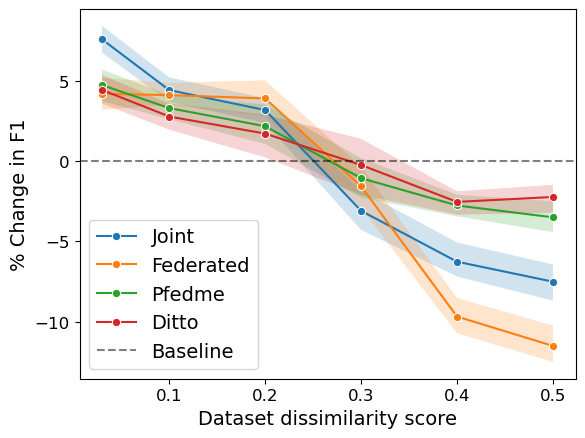

In [9]:
DATASET = 'Synthetic'
process_results(DATASET)

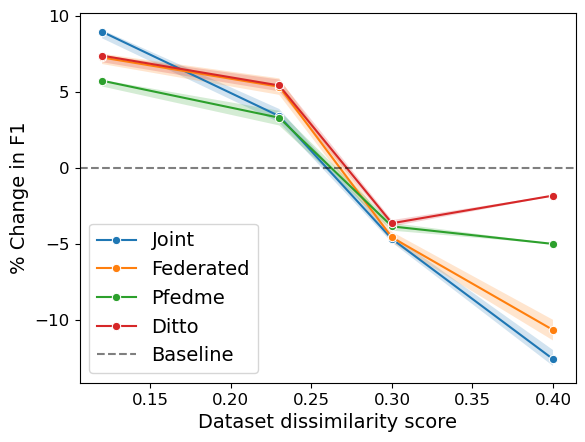

In [97]:
DATASET = 'Credit'
process_results(DATASET)

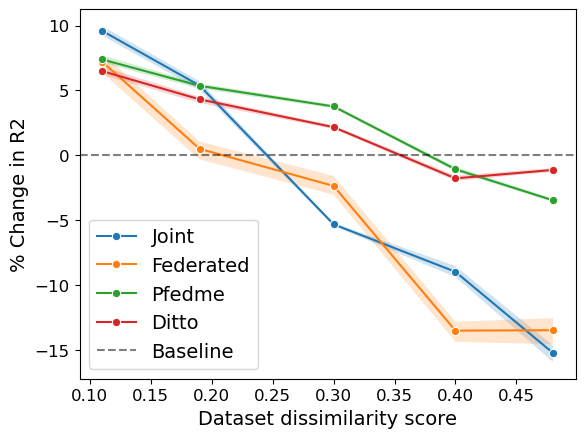

In [83]:
DATASET = 'Weather'
process_results(DATASET)

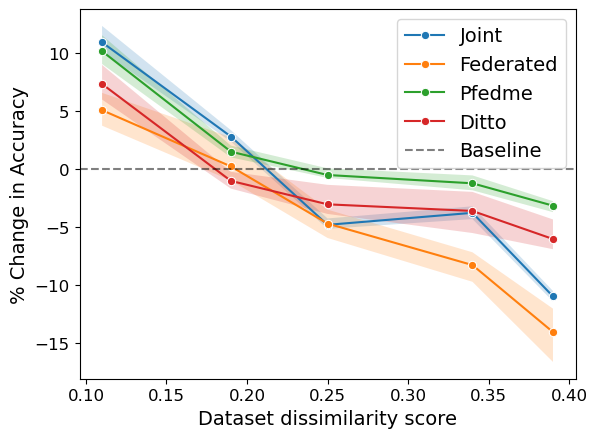

In [75]:
DATASET = 'EMNIST'
process_results(DATASET)

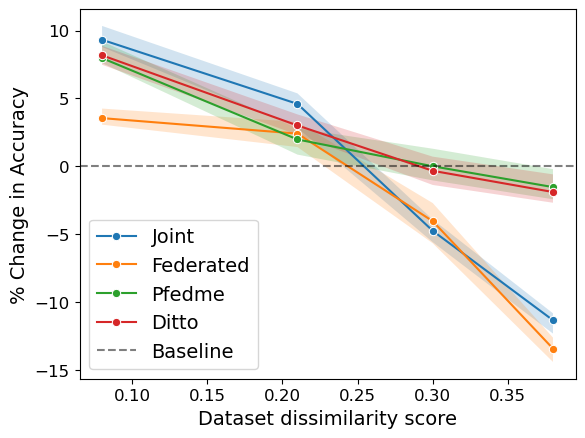

In [74]:
DATASET = 'CIFAR'
process_results(DATASET)

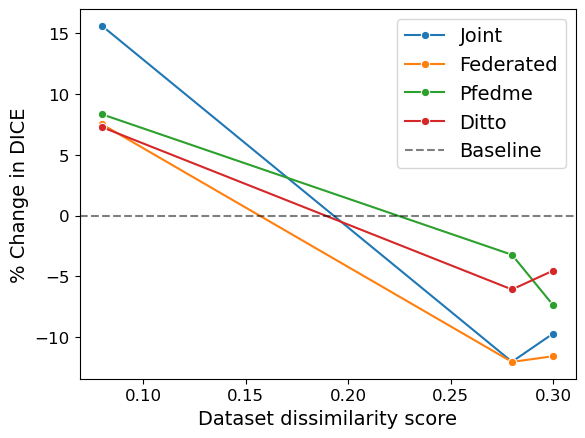

In [73]:
DATASET = 'IXITiny'
process_results(DATASET)

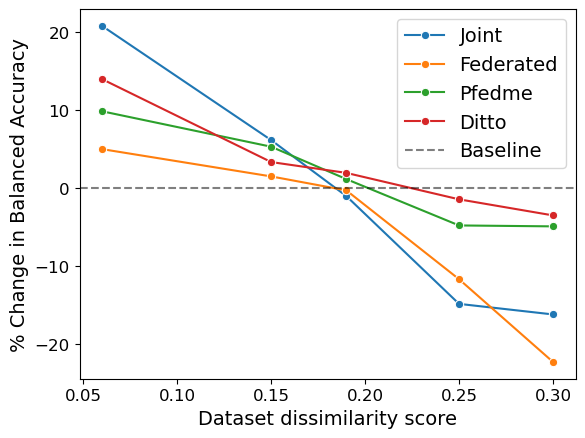

In [64]:
DATASET = 'ISIC'
process_results(DATASET)

# Other Synthetic that are discordant

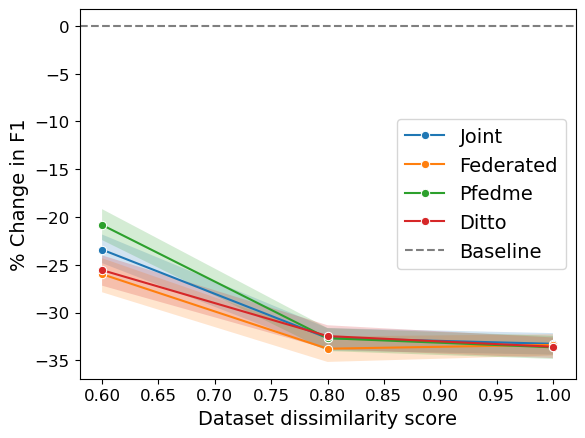

In [8]:
with open('/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase/results/Synthetic/Synthetic_scores_full_discordant.pkl', 'rb') as f:
    results = pickle.load(f)
DATASET = 'Synthetic'
save = True
results_estimates = bootstrap_ci(results, alpha=0.95)
results_diff_estimates = get_difference_estimates(results)
metric, costs = 'F1', '0.6-1.0'
results_long = results_diff_estimates.reset_index().rename(columns={'index': 'cost'}).melt(id_vars=['cost'], var_name='architecture')
results_long[['median_diff', 'lower_ci_diff', 'upper_ci_diff']] = pd.DataFrame(results_long['value'].tolist(), index=results_long.index)
results_long.drop(columns=['value'], inplace=True)
results_long
plt.figure()
for architecture in results_long['architecture'].unique():
    subset = results_long[results_long['architecture'] == architecture]
    sns.lineplot(x='cost', y='median_diff', marker = 'o', data=subset, label=architecture.capitalize())
    if DATASET not in ['IXITiny', 'ISIC']:
        plt.fill_between(x=subset['cost'], y1=subset['lower_ci_diff'], y2=subset['upper_ci_diff'], alpha=0.2)
plt.axhline(y=0, color='black', linestyle = '--', alpha = 0.5, label = 'Baseline')
plt.xlabel('Dataset dissimilarity score', fontsize = 14)
plt.ylabel(f'% Change in {metric}', fontsize = 14)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
if save == True:
    plt.savefig(f'{SAVE_DIR}/{DATASET}/{DATASET}_discordant_scores_change.pdf', bbox_inches='tight')
plt.show()